In [ ]:
!pip install gymnasium

Looking in indexes: https://mirrors.ustc.edu.cn/pypi/simple, https://pypi.org/simple


In [1]:
import gymnasium as gym
import matplotlib.pyplot as plt
import imageio
from IPython.display import Video
import torch
import numpy as np
from agent import QLearningAgent,DQNAgent,REINFORCE,ActorCritic

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
env = gym.make("LunarLander-v3", render_mode="rgb_array")
observation, info = env.reset(seed=42)

def show_env(env):
    frame = env.render()
    plt.imshow(frame)
    plt.axis('off')
    plt.show()

def plot(x,ylabel='Loss'):
    # === Plot ===
    plt.xlabel('Episode')
    plt.ylabel(ylabel)
    plt.plot(range(len(x)), x)
    plt.show()

In [3]:
print('动作空间：', env.action_space)
print('观察空间: ', env.observation_space) # 8个值的区间
# 观察就是部分状态

动作空间： Discrete(4)
观察空间:  Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ], (8,), float32)


In [ ]:
frames = []

while True:
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    frame = env.render()
    frames.append(frame)
    if terminated or truncated:
        break

# 保存为视频
imageio.mimsave('lunarlander.mp4', frames, fps=30)
Video('lunarlander.mp4', embed=True)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [ ]:
agent = QLearningAgent(
        state_size=8,
        action_size=2,
        device=device)
agent.qnet.to(device)  # 模型转到GPU

episodes = 1000
loss_history = []

for episode in range(episodes):
    state, info = env.reset()
    total_loss, cnt = 0, 0
    terminated = False
    truncated = False

    while not (terminated or truncated):
        action = agent.getAction(state)
        next_state, reward, terminated, truncated, info = env.step(action)

        loss = agent.update(state, action, reward, next_state, terminated or truncated)
        total_loss += loss
        cnt += 1
        state = next_state

    average_loss = total_loss / cnt
    if episode % 10 == 0 :
        print(f'Episode {episode}, Average Loss: {average_loss:.4f}')
    loss_history.append(average_loss)

Episode 0, Average Loss: 172.4655
Episode 10, Average Loss: 21.6450


KeyboardInterrupt: 

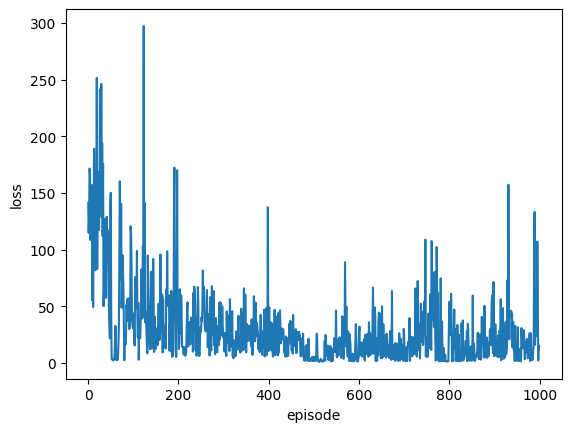

In [ ]:
plt.xlabel('episode')
plt.ylabel('loss')
plt.plot(range(len(loss_history)), loss_history)
plt.show()

In [ ]:
# 保存权重
torch.save(agent.qnet.state_dict(), "lunar_lander.pth")

In [7]:
# Test the trained agent
def test_agent(agent, env, num_episodes=1000):
    """Test agent performance without learning or exploration."""
    total_rewards = []

    # Temporarily disable exploration for testing
    # old_epsilon = agent.epsilon
    # agent.epsilon = 0.0  # Pure exploitation

    for _ in range(num_episodes):
        obs, info = env.reset()
        episode_reward = 0
        done = False

        while not done:
            action = agent.get_action(obs)[0]
            obs, reward, terminated, truncated, info = env.step(action)
            episode_reward += reward
            done = terminated or truncated

        total_rewards.append(episode_reward)


    print(f"Test Results over {num_episodes} episodes:")
    print(f"Win Rate: {np.mean(np.array(total_rewards) > 0):.1%}")
    print(f"Average Reward: {np.mean(total_rewards):.3f}")
    print(f"Standard Deviation: {np.std(total_rewards):.3f}")

In [ ]:
state.shape

(8,)

In [ ]:
agent = DQNAgent(
    lr=0.01,
    epsilon=0.1,
    batch_size=1024,
    state_size=8,
    action_size=2,
    device=device,
    use_cnn=False
    )

episodes = 2000
loss_history = []

for episode in range(episodes):
    state, info = env.reset()
    total_loss, cnt = 0, 0
    terminated = False
    truncated = False

    while not (terminated or truncated):
        action = agent.get_action(state)
        next_state, reward, terminated, truncated, info = env.step(action)

        loss = agent.update(state, action, reward, next_state, terminated or truncated)
        total_loss += loss
        cnt += 1
        state = next_state

    average_loss = total_loss / cnt
    if episode % 10 == 0 :
        print(f'Episode {episode}, Average Loss: {average_loss:.4f}')
    loss_history.append(average_loss)

Episode 0, Average Loss: 0.0000
Episode 10, Average Loss: 0.0000


AttributeError: 'DQNAgent' object has no attribute 'transforms'

In [8]:
test_agent(agent, env)

Test Results over 1000 episodes:
Win Rate: 19.7%
Average Reward: -56.494
Standard Deviation: 74.794


In [4]:
agent = REINFORCE(
    lr=0.001,
    action_size=4)
reward_history = []
episodes=20000

for episode in range(episodes):
    state, info = env.reset()
    terminated = False
    truncated = False
    sum_reward = 0
    total_loss, cnt = 0, 0

    while not (terminated or truncated): 
        action, prob = agent.get_action(state)
        next_state, reward,  terminated, truncated, info = env.step(action)

        agent.add(reward, prob)
        state = next_state
        sum_reward += reward

    total_loss += agent.update()
    cnt += 1

    reward_history.append(sum_reward)
    average_loss = total_loss / cnt
    if episode % 100 == 0:
        print("episode :{}, total reward : {:.1f}, average loss : {:.4f}".format(episode, sum_reward, average_loss))


episode :0, total reward : -162.6, average loss : -8812.8857
episode :100, total reward : -129.6, average loss : -6286.9941
episode :200, total reward : -144.9, average loss : -5791.3062
episode :300, total reward : -303.8, average loss : -16603.7871
episode :400, total reward : -144.2, average loss : -7619.1284
episode :500, total reward : -189.8, average loss : -10087.3506
episode :600, total reward : -108.5, average loss : -5480.4326
episode :700, total reward : -72.0, average loss : -3580.7927
episode :800, total reward : -4.7, average loss : -416.8204
episode :900, total reward : -13.4, average loss : -1322.9702
episode :1000, total reward : 18.3, average loss : 995.8843
episode :1100, total reward : -18.7, average loss : -489.3797
episode :1200, total reward : 11.4, average loss : 853.0017
episode :1300, total reward : -63.3, average loss : -2988.8928
episode :1400, total reward : 6.5, average loss : -778.5987
episode :1500, total reward : 72.8, average loss : 2049.4636
episode :

In [6]:
test_agent(agent, env)

NameError: name 'test_agent' is not defined

In [4]:
agent = ActorCritic(
    action_size=4,
    device='cpu',
    lr_pi=0.001,
    lr_v=0.0005,
    gamma=0.98
)
reward_history = []
episodes=5000

for episode in range(episodes):
    state, info = env.reset()
    done = False
    sum_reward = 0

    while not done: 
        action, action_probs = agent.get_action(state)
        next_state, reward,  terminated, truncated, info = env.step(action)
        
        done = (terminated or truncated)
        agent.update(state, action, action_probs, reward, next_state, done)
        state = next_state
        sum_reward += reward
        

    reward_history.append(sum_reward)

    if episode % 100 == 0:
        print("episode :{}, total reward : {:.1f}".format(episode, sum_reward))

episode :0, total reward : -142.1
episode :100, total reward : -38.7
episode :200, total reward : -124.3


KeyboardInterrupt: 

In [6]:
test_agent(agent, env)

NameError: name 'test_agent' is not defined